In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import csv
from torch import nn
from sklearn.utils import class_weight
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

torch.manual_seed(0)

DATA_PATH = '/home/skrhakv/deeplife/deeplife-project/data'
ESM_EMBEDDINGS_PATH = '/home/skrhakv/esm2/embeddings-3B-deeplife'
PROTBERT_EMBEDDINGS_PATH = '/home/skrhakv/protbert/embeddings-deeplife'
MODELS_PATH = '/home/skrhakv/deeplife/deeplife-project/models'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Train a classifier on HOLO sequence and evaluate on APO vs. HOLO sequences

### Load the dataset

In [3]:
class SequenceCryptoBenchDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        Xs_list = None
        Ys_list = None
        for key in _Xs.keys():
            if Xs_list is None:
                Xs_list = _Xs[key]
                Ys_list = _Ys[key]
            else:
                Xs_list = np.concatenate((Xs_list,_Xs[key]), axis = 0)
                Ys_list = np.concatenate((Ys_list,_Ys[key]), axis = 0)

        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y

def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id],embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                # Yu dataset has 1-based indexing, so we need to subtract 1
                assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

    return Xs, Ys

In [3]:
Xs_train_holo, Ys_train_holo = process_sequence_dataset(f'{DATA_PATH}/holo_train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_holo = SequenceCryptoBenchDataset(Xs_train_holo, Ys_train_holo)

Xs_test_holo, Ys_test_holo = process_sequence_dataset(f'{DATA_PATH}/holo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_holo = SequenceCryptoBenchDataset(Xs_test_holo, Ys_test_holo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

In [110]:
DROPOUT = 0.3
LAYER_WIDTH = 1000
ESM2_DIM = 2560
class CryptoBenchClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout1(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### TRAIN
Train the method on HOLO sequences, evaluate on APO and HOLO test set.

In [7]:
model_0 = CryptoBenchClassifier().to(device)
epochs = 120

# Create an optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.0001)

X_train, y_train = train_dataset_holo[:]
X_test_holo, y_test_holo = test_dataset_holo[:]
X_test_apo, y_test_apo = test_dataset_apo[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
print(f'Class weights: {class_weights}')

# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test_holo, y_test_holo = X_test_holo.to(device), y_test_holo.to(device).float()
X_test_apo, y_test_apo = X_test_apo.to(device), y_test_apo.to(device).float()

train_losses, test_losses_holo, test_losses_apo = [], [], []

for epoch in range(epochs):

    #
    # TRAIN
    #
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    train_losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #
    # TEST
    #
    model_0.eval()
    with torch.inference_mode():
        #
        # test for HOLO
        #
        test_logits = model_0(X_test_holo).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss_holo = loss_fn(test_logits,
                            y_test_holo)
        test_losses_holo.append(test_loss_holo.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc_holo = accuracy_fn(y_true=y_test_holo,
                               y_pred=test_pred)
        fpr_holo, tpr_holo, thresholds_holo = metrics.roc_curve(y_test_holo.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc_holo = metrics.auc(fpr_holo, tpr_holo)

        mcc_holo = metrics.matthews_corrcoef(y_test_holo.cpu().numpy(), test_pred.cpu().numpy())
        
        #
        # test for APO
        #
        test_logits = model_0(X_test_apo).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss_apo = loss_fn(test_logits,
                            y_test_apo)
        test_losses_apo.append(test_loss_apo.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc_apo = accuracy_fn(y_true=y_test_apo,
                               y_pred=test_pred)
        fpr_apo, tpr_apo, thresholds_apo = metrics.roc_curve(y_test_apo.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc_apo = metrics.auc(fpr_apo, tpr_apo)

        mcc_apo = metrics.matthews_corrcoef(y_test_apo.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"APO  - Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc_apo:.2f}% | Test loss: {test_loss_apo:.5f}, AUC: {roc_auc_apo}, MCC: {mcc_apo}")
        print(f"HOLO - Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc_holo:.2f}% | Test loss: {test_loss_holo:.5f}, AUC: {roc_auc_holo}, MCC: {mcc_holo}")

Class weights: tensor([ 0.5183, 14.1635], device='cuda:0')
APO  - Epoch: 0 | Loss: 1.79801, Accuracy: 5.35% | Test loss: 4.37182, AUC: 0.6325960962168735, MCC: 0.0014048794849757385
HOLO - Epoch: 0 | Loss: 1.79801, Accuracy: 3.76% | Test loss: 4.44268, AUC: 0.63079259295557, MCC: -0.003753443652197668
APO  - Epoch: 10 | Loss: 1.65854, Accuracy: 57.81% | Test loss: 1.22745, AUC: 0.8029666119302821, MCC: 0.18644618121556492
HOLO - Epoch: 10 | Loss: 1.65854, Accuracy: 56.64% | Test loss: 1.20320, AUC: 0.7996326504673101, MCC: 0.15501320428621027
APO  - Epoch: 20 | Loss: 0.97564, Accuracy: 79.91% | Test loss: 0.97459, AUC: 0.8255989656018105, MCC: 0.27079007147739237
HOLO - Epoch: 20 | Loss: 0.97564, Accuracy: 79.28% | Test loss: 0.84681, AUC: 0.8234432577707194, MCC: 0.22739166016166476
APO  - Epoch: 30 | Loss: 0.90882, Accuracy: 90.84% | Test loss: 1.11350, AUC: 0.8305175226615887, MCC: 0.32343241223976665
HOLO - Epoch: 30 | Loss: 0.90882, Accuracy: 91.03% | Test loss: 0.83284, AUC: 0.83

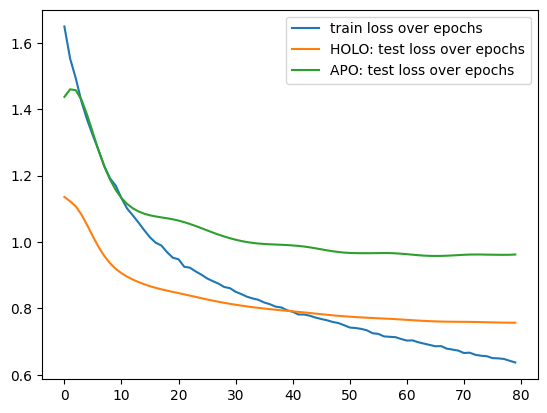

In [16]:
plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses_holo,label="HOLO: test loss over epochs")
plt.plot(test_losses_apo,label="APO: test loss over epochs")
plt.legend()

### plot ROC curve
As you can se below, the performance for APO and HOLO is nearly identical  

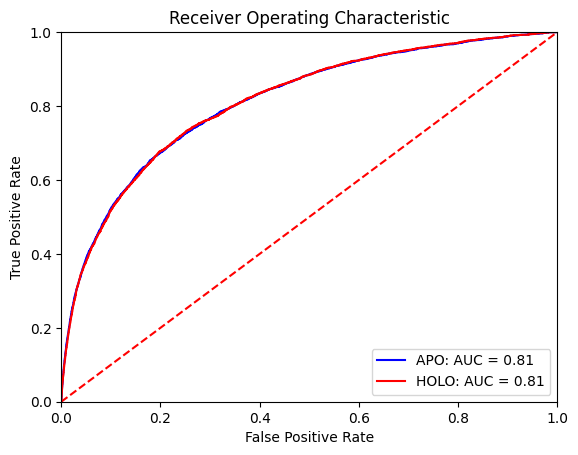

In [18]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_apo, tpr_apo, 'b', label = 'APO: AUC = %0.2f' % roc_auc_apo)
plt.plot(fpr_holo, tpr_holo, 'r', label = 'HOLO: AUC = %0.2f' % roc_auc_holo)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Save the model & cleanup

In [19]:
torch.save(model_0.state_dict(), f'{MODELS_PATH}/holo_sequence_model.pth')

# TODO: delete all the 'heavy' variables to free RAM

# TRAIN STRUCTURE-BASED METHOD

In [7]:
import gc
import pickle
import os
from sklearn.metrics import confusion_matrix

HOLO_VOXEL_FEATURES_PATH = '/home/skrhakv/deeplife/deeplife-project/data/holo-voxel-features'
HOLO_VOXEL_ANNOTATIONS_PATH = '/home/skrhakv/deeplife/deeplife-project/data/holo-voxel-annotations'
APO_VOXEL_FEATURES_PATH = '/home/skrhakv/deeplife/deeplife-project/data/apo-voxel-features'
APO_VOXEL_ANNOTATIONS_PATH = '/home/skrhakv/deeplife/deeplife-project/data/apo-voxel-annotations'

WINDOW_SIZE = 16
WINDOW_STEP = 8

BATCH_SIZE = 2048

# splits the protein into 3D windows
def sliding_window_3d(vector):
    vector = vector.unfold(1,WINDOW_SIZE,WINDOW_STEP)
    vector = vector.unfold(2,WINDOW_SIZE,WINDOW_STEP)
    vector = vector.unfold(3,WINDOW_SIZE,WINDOW_STEP)
    return vector.flatten(1, 3)


def pad_and_sliding_window_3d(x, y):
    pad1 = WINDOW_SIZE - x.shape[3] % WINDOW_SIZE if WINDOW_SIZE - x.shape[3] % WINDOW_SIZE > 0 else 0
    pad2 = WINDOW_SIZE - x.shape[2] % WINDOW_SIZE if WINDOW_SIZE - x.shape[2] % WINDOW_SIZE > 0 else 0
    pad3 = WINDOW_SIZE - x.shape[1] % WINDOW_SIZE if WINDOW_SIZE - x.shape[1] % WINDOW_SIZE > 0 else 0

    x = torch.tensor(x, dtype=torch.float16)
    y = torch.tensor(y, dtype=torch.int8)

    # add padding to the voxel grid
    x = F.pad(x, (int(pad1 / 2), int(pad1 / 2) + (pad1 % 2 > 0),
        int(pad2 / 2), int(pad2 / 2) + (pad2 % 2 > 0),
        int(pad3 / 2), int(pad3 / 2) + (pad3 % 2 > 0)), mode='constant', value=0)
    y = F.pad(y, (int(pad1 / 2), int(pad1 / 2) + (pad1 % 2 > 0),
        int(pad2 / 2), int(pad2 / 2) + (pad2 % 2 > 0),
        int(pad3 / 2), int(pad3 / 2) + (pad3 % 2 > 0)), mode='constant', value=0)

    # split the protein into 3D windows
    x = sliding_window_3d(x)
    y = sliding_window_3d(y)

    return x,y

class VoxelCryptoBenchDataset(Dataset):
    def __init__(self, _Xs= None, _Ys= None):
        self.Xs = None
        self.Ys = None

        if _Xs is None or _Ys is None:
            return
        counter = 1
        keys = list(_Xs.keys())
        for key in keys:
            print(key, ' ',counter, ' / ', len(keys), ' ')
            counter += 1

            x, y = pad_and_sliding_window_3d(_Xs[key], _Ys[key])
            y = y.sum(dim=[0,2,3,4]) > 0
            if self.Xs is None:
                self.Xs = x
                self.Ys = y
            else:
                self.Xs = torch.cat((self.Xs,x),1)
                self.Ys = torch.cat((self.Ys,y))

            if counter % 5 == 0:
                gc.collect()

            del _Xs[key]
            del _Ys[key]

        self.Xs = self.Xs.swapaxes(0,1)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y
    
class VoxelCryptoBenchCNN(nn.Module):
    def __init__(self):
        super(VoxelCryptoBenchCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=8,
                               out_channels=2,
                               kernel_size = 5,
                               stride=2,
                               padding=2)



        self.maxpool1 = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)

        self.dropout1 = nn.Dropout(0.25)

        self.linear1 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.25)

        self.linear2 = nn.Linear(512, 1)


    def forward(self, x):
        x = self.conv1(x)

        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = torch.flatten(x,1)

        x = self.linear1(x)
        x = self.dropout2(x)
        x = F.relu(x)

        x = self.linear2(x)
        return x


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def proccess_voxel_dataset(annotation_path, voxel_features_path, voxel_annotation_path):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            filename = id + '.npy'
            
            if not os.path.isfile(f'{voxel_features_path}/{filename}') or \
                not os.path.isfile(f'{voxel_annotation_path}/{filename}'):
                print(f'{id} not present, skipping ...')
                continue
            if id not in Xs:
                voxel_features = np.load(f'{voxel_features_path}/{filename}')
                Xs[id] = np.transpose(voxel_features, (3, 1, 2, 0))

            if id not in Ys:
                voxel_annotations = np.load(f'{voxel_annotation_path}/{filename}')
                Ys[id] = np.transpose(voxel_annotations, (3, 1, 2, 0))


    return Xs, Ys

def test_structure_model(model, test_dataset, loss_fn):
    model.eval()

    with torch.inference_mode():

        # prepare the test 
        test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

        for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
            test_logits = model(x_batch.float().to(device)).squeeze().to(device)
            y_test = y_batch
            
        # compute the metrics
        test_pred = torch.round(torch.sigmoid(test_logits))
        y_test = y_test.to(device).float()
        test_loss = loss_fn(test_logits,
                            y_test.to(device))
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy(), pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
        print(confusion_matrix(y_test.cpu().numpy(), test_pred.cpu().numpy()))
        counter = 0
        for i in range(len(y_test)):
            if y_test[i] == 1 and test_pred[i] == 0:
                counter  += 1
        print(counter)
        print(f"Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}")

        return fpr, tpr, roc_auc


In [3]:
print('Loading dataset from .npy files ...')
holo_Xs_train, holo_Ys_train = proccess_voxel_dataset(f'{DATA_PATH}/holo_train.txt', HOLO_VOXEL_FEATURES_PATH, HOLO_VOXEL_ANNOTATIONS_PATH)

print('Create VoxelYuDataset instance ...')
holo_train_dataset = VoxelCryptoBenchDataset(holo_Xs_train, holo_Ys_train)

Loading dataset from .npy files ...
7f98A not present, skipping ...
7uxzAAA not present, skipping ...
8gydB not present, skipping ...
1n3pA not present, skipping ...
1n3pA not present, skipping ...
1n3pA not present, skipping ...
1n3pA not present, skipping ...
6zdmAAA not present, skipping ...
2icyA not present, skipping ...
3ar3A not present, skipping ...
6zdlAAA not present, skipping ...
4wwlA not present, skipping ...
4ar3A not present, skipping ...
8hawA not present, skipping ...
7xb8B not present, skipping ...
6oiiA not present, skipping ...
6oiiA not present, skipping ...
7qxtAAA not present, skipping ...
2wtxA not present, skipping ...
2wtxA not present, skipping ...
3edfB not present, skipping ...
3edfB not present, skipping ...
3edkA not present, skipping ...
3edkA not present, skipping ...
3edkA not present, skipping ...
1ta6A not present, skipping ...
1tq7B not present, skipping ...
7nbgBBB not present, skipping ...
2zm7A not present, skipping ...
8aerA not present, skippin

: 

5ys5A   326  /  1388  
2x88A   327  /  1388  
6w2kB   328  /  1388  
4wfjA   329  /  1388  
5zrqA   330  /  1388  
5zrrA   331  /  1388  
2dcfA   332  /  1388  
3cyzA   333  /  1388  
3cyzB   334  /  1388  
7adsA   335  /  1388  
4di8A   336  /  1388  
6zamA   337  /  1388  
7qk4A   338  /  1388  
5h1yA   339  /  1388  
3noiB   340  /  1388  
8q44B   341  /  1388  
6ksvA   342  /  1388  
1h5vA   343  /  1388  
4fnyA   344  /  1388  
5ftoA   345  /  1388  
3gezA   346  /  1388  
1rwfA   347  /  1388  
2wdaA   348  /  1388  
4duqA   349  /  1388  
6q3uA   350  /  1388  
1wdnA   351  /  1388  
1lafE   352  /  1388  
6ml9E   353  /  1388  
2ylnA   354  /  1388  
1re3C   355  /  1388  
7ljlA   356  /  1388  
7d5gA   357  /  1388  
5sddA   358  /  1388  
5sdiA   359  /  1388  
7aaxA   360  /  1388  
2jhlF   361  /  1388  
2ouhA   362  /  1388  
1a95B   363  /  1388  
3nx2A   364  /  1388  
2xs7A   365  /  1388  
6jsaA   366  /  1388  
5ph6A   367  /  1388  
5phdA   368  /  1388  
5phfA   369

In [4]:
with open(f'{DATA_PATH}/holo_train_dataset.pickle', 'wb') as handle:
    pickle.dump(holo_train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
with open(f'{DATA_PATH}/holo_train_dataset.pickle', 'rb') as f:
    holo_train_dataset = pickle.load(f)

In [5]:
X_train_holo, y_train_holo = holo_train_dataset[:]

np_list = []
for i in y_train_holo:
    np_list.append(i.numpy().flatten())
    
y_train_concatenated = np.concatenate(np_list)

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train_concatenated).to(device)

In [8]:
model_1 = VoxelCryptoBenchCNN().to(device)

# Create an optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.0001)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
epochs = 20


for epoch in range(epochs):
    ### TRAIN
    print(f"Epoch {epoch}")

    model_1.train()

    train_dataloader = DataLoader(holo_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
        print(f"Epoch {epoch}, batch {id_batch} / {BATCH_SIZE}")

        X_train, y_train = x_batch.to(device), y_batch.to(device).float()

        y_logits = model_1(X_train.float()).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits,
                        y_train)
        acc = accuracy_fn(y_true=y_train,
                            y_pred=y_pred)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

Epoch 0
Epoch 0, batch 0 / 2048
Epoch 0, batch 1 / 2048
Epoch 0, batch 2 / 2048
Epoch 0, batch 3 / 2048
Epoch 0, batch 4 / 2048
Epoch 0, batch 5 / 2048
Epoch 0, batch 6 / 2048
Epoch 0, batch 7 / 2048
Epoch 0, batch 8 / 2048
Epoch 0, batch 9 / 2048
Epoch 0, batch 10 / 2048
Epoch 0, batch 11 / 2048
Epoch 0, batch 12 / 2048
Epoch 0, batch 13 / 2048
Epoch 0, batch 14 / 2048
Epoch 0, batch 15 / 2048
Epoch 0, batch 16 / 2048
Epoch 0, batch 17 / 2048
Epoch 0, batch 18 / 2048
Epoch 0, batch 19 / 2048
Epoch 0, batch 20 / 2048
Epoch 0, batch 21 / 2048
Epoch 0, batch 22 / 2048
Epoch 0, batch 23 / 2048
Epoch 0, batch 24 / 2048
Epoch 0, batch 25 / 2048
Epoch 0, batch 26 / 2048
Epoch 0, batch 27 / 2048
Epoch 0, batch 28 / 2048
Epoch 0, batch 29 / 2048
Epoch 0, batch 30 / 2048
Epoch 0, batch 31 / 2048
Epoch 0, batch 32 / 2048
Epoch 0, batch 33 / 2048
Epoch 0, batch 34 / 2048
Epoch 0, batch 35 / 2048
Epoch 0, batch 36 / 2048
Epoch 0, batch 37 / 2048
Epoch 0, batch 38 / 2048
Epoch 0, batch 39 / 2048
Ep

### Save the trained model

In [9]:
MODELS_PATH = '/home/skrhakv/deeplife/deeplife-project/models'

torch.save(model_1.state_dict(), f'{MODELS_PATH}/holo_structure_model_window16.pth')

### load holo test set

In [10]:
print('Loading dataset from .npy files ...')
holo_Xs_test, holo_Ys_test = proccess_voxel_dataset(f'{DATA_PATH}/holo_test.txt', HOLO_VOXEL_FEATURES_PATH, HOLO_VOXEL_ANNOTATIONS_PATH)

print('Create VoxelCryptoBenchDataset instance ...')
holo_test_dataset = VoxelCryptoBenchDataset(holo_Xs_test, holo_Ys_test)

Loading dataset from .npy files ...
6mu3H not present, skipping ...
7fsiD not present, skipping ...
7fsiD not present, skipping ...
8bbzCCC not present, skipping ...
2znzA not present, skipping ...
5o6oA not present, skipping ...
5o6oA not present, skipping ...
6g4lA not present, skipping ...
6g4lA not present, skipping ...
6u1dA not present, skipping ...
6u1dA not present, skipping ...
6u1dA not present, skipping ...
6u1dA not present, skipping ...
6u1dA not present, skipping ...
8evxA not present, skipping ...
8evxA not present, skipping ...
8evxA not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
7fc9A not present, skipping ...
3mvrA not present, skipping ...
3mvrA not present, skipping ...
3tmzA not present, skipping ...
3tmzA not present, skipping ...
6bwwA not present, skipping ...
6bwwA not present, skipping ...
5c

In [23]:
with open(f'{DATA_PATH}/holo_test_dataset.pickle', 'wb') as handle:
    pickle.dump(holo_test_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
model_1.eval()

with torch.inference_mode():

    # prepare the test 
    test_dataloader = DataLoader(holo_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # make the predictions (batch the predictions just in case GPU doesn't have enough memory)
    test_logits = None
    y_test = None

    for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
        if test_logits == None:
            test_logits = model_1(x_batch.float().to(device)).squeeze().to(device)
            y_test = y_batch
        else:
            test_logits = torch.cat((test_logits, model_1(x_batch.float().to(device)).squeeze()))
            y_test = torch.cat((y_test, y_batch))
    
    # compute the metrics
    test_pred = torch.round(torch.sigmoid(test_logits))
    y_test = y_test.to(device).float()
    test_loss = loss_fn(test_logits,
                        y_test.to(device))
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
    roc_auc_1 = metrics.auc(fpr_1, tpr_1)
    mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    
    print(f"Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc_1}, MCC: {mcc}")

Accuracy: 84.04% | Test loss: 0.49751, AUC: 0.9106868014541281, MCC: 0.4074873705853471


### Stats

In [12]:
print('Windows per protein: ', len(holo_test_dataset) / 369)
print(f'Class weights: ', class_weights)

Windows per protein:  759.4661246612466
Class weights:  tensor([0.5362, 7.4047], device='cuda:0')


In [13]:
print('Loading dataset from .npy files ...')
apo_Xs_test, apo_Ys_test = proccess_voxel_dataset(f'{DATA_PATH}/apo_test.txt', APO_VOXEL_FEATURES_PATH, APO_VOXEL_ANNOTATIONS_PATH)

print('Create VoxelCryptoBenchDataset instance ...')
apo_test_dataset = VoxelCryptoBenchDataset(apo_Xs_test, apo_Ys_test)

Loading dataset from .npy files ...
6n32K not present, skipping ...
8bhuAAA not present, skipping ...
7av9AAA not present, skipping ...
2e1cA not present, skipping ...
5cxgD not present, skipping ...
Create VoxelCryptoBenchDataset instance ...
3li0B   1  /  283  
4wmbD   2  /  283  
3a7gA   3  /  283  
1k3aA   4  /  283  
6cwmA   5  /  283  
8a0lB   6  /  283  
5niaA   7  /  283  
2xq0A   8  /  283  
1s8cC   9  /  283  
1jcdB   10  /  283  
3vzcA   11  /  283  
2xe6A   12  /  283  
3wrfA   13  /  283  
3wxlD   14  /  283  
5yi0A   15  /  283  
6bunD   16  /  283  
4goyA   17  /  283  
1b8cA   18  /  283  
6ifqA   19  /  283  
6u9cC   20  /  283  
1wt9A   21  /  283  
5o2kB   22  /  283  
8gw5B   23  /  283  
1l0wB   24  /  283  
2o1cD   25  /  283  
5z6dA   26  /  283  
2f1sA   27  /  283  
5xnfB   28  /  283  
7xutA   29  /  283  
3ac9A   30  /  283  
1kh0B   31  /  283  
4hzrA   32  /  283  
2ixmA   33  /  283  
5n0xB   34  /  283  
6jkyB   35  /  283  
5f3kB   36  /  283  
5z59A   3

In [7]:
model_1 = VoxelCryptoBenchCNN().to(device)
model_1.load_state_dict(torch.load(f'{MODELS_PATH}/holo_structure_model.pth'))


VoxelCryptoBenchCNN(
  (conv1): Conv3d(8, 2, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=(2, 2, 2))
  (maxpool1): MaxPool3d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (linear1): Linear(in_features=8192, out_features=2048, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (linear2): Linear(in_features=2048, out_features=1, bias=True)
)

In [14]:
# the class weights were: [0.6551, 2.1119]
fpr_apo, tpr_apo, roc_auc_apo = test_structure_model(model_1, apo_test_dataset, nn.BCEWithLogitsLoss(pos_weight=class_weights[1]))

[[174929  29713]
 [  4992  14589]]
4992
Accuracy: 84.52% | Test loss: 0.59200, AUC: 0.9019614921024026, MCC: 0.42531920831432846


In [44]:
print(sum(apo_test_dataset[:][1]))
16666 + 7362

tensor(24028)


24028

In [15]:
# with open(f'{DATA_PATH}/holo_test_dataset.pickle', 'rb') as f:
#     holo_test_dataset = pickle.load(f)

fpr_holo, tpr_holo, roc_auc_holo = test_structure_model(model_1, holo_test_dataset, nn.BCEWithLogitsLoss(pos_weight=class_weights[1]))

[[220022  40886]
 [  3843  15492]]
3843
Accuracy: 84.04% | Test loss: 0.49751, AUC: 0.9106868037337681, MCC: 0.4074873705853471


### results:
for window size == 32 and step size == 16:
```
APO: Accuracy: 77.02% | Test loss: 0.95414, AUC: 0.7968345005240148, MCC: 0.41047926715526967
HOLO: Accuracy: 78.90% | Test loss: 0.80221, AUC: 0.8089356415090461, MCC: 0.4313341662553757
Class weights:  tensor([0.6551, 2.1119], device='cuda:0')
Windows per protein: 100
```

for window size == 16 and step size == 8:
```
APO: Accuracy: 84.04% | Test loss: 0.49751, AUC: 0.9106868014541281, MCC: 0.4074873705853471
HOLO: Accuracy: 84.52% | Test loss: 0.59200, AUC: 0.9019614921024026, MCC: 0.42531920831432846
Windows per protein:  759.4661246612466
Class weights:  tensor([0.5362, 7.4047], device='cuda:0')

```

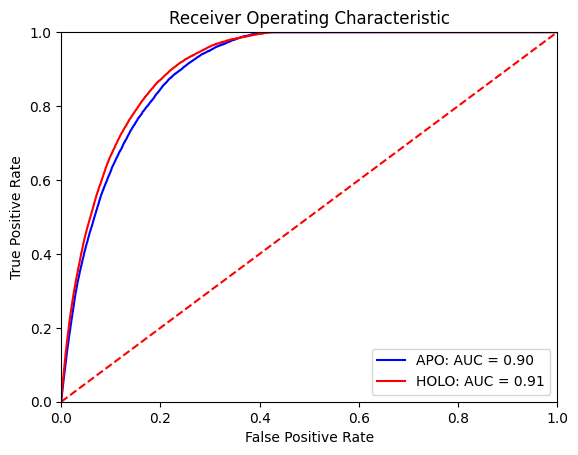

In [16]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_apo, tpr_apo, 'b', label = 'APO: AUC = %0.2f' % roc_auc_apo)
plt.plot(fpr_holo, tpr_holo, 'r', label = 'HOLO: AUC = %0.2f' % roc_auc_holo)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Train a classifier on APO sequences and evaluate on APO sequences

In [8]:
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/apo_train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

In [12]:
model_3 = CryptoBenchClassifier().to(device)
epochs = 120

# Create an optimizer
optimizer = torch.optim.Adam(params=model_3.parameters(),
                            lr=0.0001)

X_train, y_train = train_dataset_apo[:]
X_test, y_test, = test_dataset_apo[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
print(f'Class weights: ', class_weights)
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses, test_losses = [], []

for epoch in range(epochs):

    #
    # TRAIN
    #
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    train_losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #
    # TEST
    #
    model_3.eval()
    with torch.inference_mode():

        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses.append(test_loss.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}")


Class weights:  tensor([ 0.5235, 11.1424], device='cuda:0')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (343096x3584 and 2560x1000)

### Let's try merging both embeddings together (ESM2 + ProtBERT)

In [76]:
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/apo_train.txt', [ESM_EMBEDDINGS_PATH, PROTBERT_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH, PROTBERT_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

In [81]:
X_test, y_test = test_dataset_apo[:]
y_test.shape

torch.Size([85884])

In [111]:
# TODO: REFACTOR!!!! do not copypaste

PROTBERT_DIM = 1024
BATCH_SIZE = 2048

model_3 = CryptoBenchClassifier(ESM2_DIM + PROTBERT_DIM).to(device)
epochs = 15

# Create an optimizer
optimizer = torch.optim.Adam(params=model_3.parameters(),
                            lr=0.0001,
                            weight_decay=5e-4)

X_train, y_train = train_dataset_apo[:]
X_test, y_test, = test_dataset_apo[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
print(f'Class weights: ', class_weights)
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses, test_losses = [], []

sample_weights = [0] * len(y_train.numpy())

for idx, label in enumerate(y_train.numpy()):
    sample_weights[idx] = class_weights[label]

sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
train_dataloader = DataLoader(train_dataset_apo, batch_size=BATCH_SIZE, shuffle=True)#sampler=sampler)

for epoch in range(epochs):
    #
    # TRAIN
    #
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).float()

        model_3.train()

        y_logits = model_3(x_batch).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits,
                       y_batch)
        acc = accuracy_fn(y_true=y_batch,
                          y_pred=y_pred)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_losses.append(loss.cpu().detach().numpy())

    #
    # TEST
    #
    model_3.eval()
    with torch.inference_mode():

        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses.append(test_loss.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    #if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(test_pred)}")


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Epoch: 14 | Loss: 0.02159, Accuracy: 93.78% | Test loss: 2.92093, AUC: 0.8174355631661385, MCC: 0.32577849679911225, sum: 3700.0